In [242]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Introduction

The data below was pulled from Kaggle and is data on the top 1000 movies of all time

https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

Some of the questions that we have are:
1. Is genre correlated to runtime?
2. Which genre has a higher IMDB rating (aka audience rating)?
3. Which genre has the most movies?

### Prepare and wrangle the data

In [243]:
# Read in the data
movie_df = pd.read_csv('imdb_top_1000.csv')
movie_df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [244]:
# Here we had to split the data from runtime into two different columns, because we needed only the number for runtime
movie_df[['Runtime', 'drop']] = movie_df['Runtime'].str.split(' ', 1, expand=True)

C:\Users\Cole\AppData\Local\Temp\ipykernel_9700\3679788613.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  movie_df[['Runtime', 'drop']] = movie_df['Runtime'].str.split(' ', 1, expand=True)


In [245]:
# We dropped these columns, because they were un-needed for our analysis and did not fit into the insights/questions we wanted to answer
movie_df.drop(columns=['Poster_Link', 'Overview', 'Star1', 'Star2', 'Star3', 'Star4', 'Meta_score', 'Gross', 'Certificate', 'drop'], inplace=True)

In [246]:
# Here we did label encoding on the directors column to make all of the director names to int variables
le = LabelEncoder()
le.fit(movie_df.Director.unique())
movie_df['Director'] = le.transform(movie_df.Director)

In [247]:
# There was a problem with one of the released years of the movies so I had to do manual data entry for the one value that was messed up
movie_df['Released_Year'].replace({'PG': 1995}, inplace=True)

In [248]:
# Changed object values to int
movie_df['Released_Year'] = movie_df['Released_Year'].apply(int)
movie_df['Runtime'] = movie_df['Runtime'].apply(int)

In [249]:
# Make sure all the values that I want to be numbers are int or float
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   1000 non-null   object 
 1   Released_Year  1000 non-null   int64  
 2   Runtime        1000 non-null   int64  
 3   Genre          1000 non-null   object 
 4   IMDB_Rating    1000 non-null   float64
 5   Director       1000 non-null   int32  
 6   No_of_Votes    1000 non-null   int64  
dtypes: float64(1), int32(1), int64(3), object(2)
memory usage: 50.9+ KB


In [250]:
movie_df

,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating,Director,No_of_Votes
0,The Shawshank Redemption,1994,142,Drama,9.3,141,2343110
1,The Godfather,1972,175,"Crime, Drama",9.2,137,1620367
2,The Dark Knight,2008,152,"Action, Crime, Drama",9.0,83,2303232
3,The Godfather: Part II,1974,202,"Crime, Drama",9.0,137,1129952
4,12 Angry Men,1957,96,"Crime, Drama",9.0,456,689845
...,...,...,...,...,...,...,...
995,Breakfast at Tiffany's,1961,115,"Comedy, Drama, Romance",7.6,50,166544
996,Giant,1956,201,"Drama, Western",7.6,164,34075
997,From Here to Eternity,1953,118,"Drama, Romance, War",7.6,145,43374
998,Lifeboat,1944,97,"Drama, War",7.6,22,26471


In [251]:
# Sent all the values of the series title to a list
allmovielist = movie_df['Series_Title'].to_list()

## Drama Movies vs Non-Drama Movies

In [252]:
# Made a dataframe with all of the movies that have drama in the genre
genre = 'Drama'
drama = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin([genre]).any())]

In [253]:
drama

,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating,Director,No_of_Votes
0,The Shawshank Redemption,1994,142,Drama,9.3,141,2343110
1,The Godfather,1972,175,"Crime, Drama",9.2,137,1620367
2,The Dark Knight,2008,152,"Action, Crime, Drama",9.0,83,2303232
3,The Godfather: Part II,1974,202,"Crime, Drama",9.0,137,1129952
4,12 Angry Men,1957,96,"Crime, Drama",9.0,456,689845
...,...,...,...,...,...,...,...
993,Blowup,1966,111,"Drama, Mystery, Thriller",7.6,336,56513
995,Breakfast at Tiffany's,1961,115,"Comedy, Drama, Romance",7.6,50,166544
996,Giant,1956,201,"Drama, Western",7.6,164,34075
997,From Here to Eternity,1953,118,"Drama, Romance, War",7.6,145,43374


### Split data based off of Drama

In [254]:
# Sent all of the series title to a list
dramamovielist = drama['Series_Title'].to_list()

In [255]:
# If a movie from the drama list was in the all movie list, then 1 was added to a list if not a 0 was added to the list
outcome = []
for movie in allmovielist:
    if movie in dramamovielist:
        outcome.append(1)
    else:
        outcome.append(0)

In [256]:
# Added the list to the dataframe
drama_df = movie_df
drama_df['Outcome'] = outcome

In [257]:
drama_df

,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating,Director,No_of_Votes,Outcome
0,The Shawshank Redemption,1994,142,Drama,9.3,141,2343110,1
1,The Godfather,1972,175,"Crime, Drama",9.2,137,1620367,1
2,The Dark Knight,2008,152,"Action, Crime, Drama",9.0,83,2303232,1
3,The Godfather: Part II,1974,202,"Crime, Drama",9.0,137,1129952,1
4,12 Angry Men,1957,96,"Crime, Drama",9.0,456,689845,1
...,...,...,...,...,...,...,...,...
995,Breakfast at Tiffany's,1961,115,"Comedy, Drama, Romance",7.6,50,166544,1
996,Giant,1956,201,"Drama, Western",7.6,164,34075,1
997,From Here to Eternity,1953,118,"Drama, Romance, War",7.6,145,43374,1
998,Lifeboat,1944,97,"Drama, War",7.6,22,26471,1


In [258]:
# Set the index to the Series Title
drama_df.set_index('Series_Title', inplace=True)

In [259]:
# Created the X and y dataframes
X = drama_df.drop(columns=['Outcome', 'Genre']) 
y = drama_df.Outcome

In [260]:
X.head()

,Released_Year,Runtime,IMDB_Rating,Director,No_of_Votes
Series_Title,,,,,
The Shawshank Redemption,1994,142,9.3,141,2343110
The Godfather,1972,175,9.2,137,1620367
The Dark Knight,2008,152,9.0,83,2303232
The Godfather: Part II,1974,202,9.0,137,1129952
12 Angry Men,1957,96,9.0,456,689845


### Split the data into train and test data

In [261]:
# Create the train and test data for X and Y
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

### Use scikit-learn Logistic Regression for training and testing your model

In [262]:
# Start the Logistic Regression
LogReg = LogisticRegression()

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LogReg.fit(X_train,y_train)

y_pred=LogReg.predict(X_test)

In [263]:
print('Classes', LogReg.classes_)
print('Intercept',LogReg.intercept_)
print("Coefficients", LogReg.coef_ )

Classes [0 1]
Intercept [1.12926775]
Coefficients [[ 0.46929858  0.59353817  0.56524343 -0.08354393 -0.85589352]]


### Precision, Recall, and F1-score

Precision is the proportion of the predicted positives that are true positives.
Recall is the proportion of the true positives that are predicted as positives.
The F1 score is a measure of accuracy; it is the harmonic mean of the precision and recall

In [264]:
print("Accuracy", LogReg.score(X_test, y_test))
print(classification_report(y_test, LogReg.predict(X_test)))

Accuracy 0.776
              precision    recall  f1-score   support

           0       0.67      0.28      0.39        65
           1       0.79      0.95      0.86       185

    accuracy                           0.78       250
   macro avg       0.73      0.61      0.63       250
weighted avg       0.76      0.78      0.74       250



In [265]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[ 18,  47],
       [  9, 176]], dtype=int64)

### Plot the Confusion Matrix

In the confusion matrix above rows represent actual values and columns represent predicted values. The outcome of the confusion matrix is that there were 18 True Negative Values, 47 False Positive Values, 9 False Negative Values, and 176 True Positive Values.

Text(0.5, 427.9555555555555, 'Predicted Values')

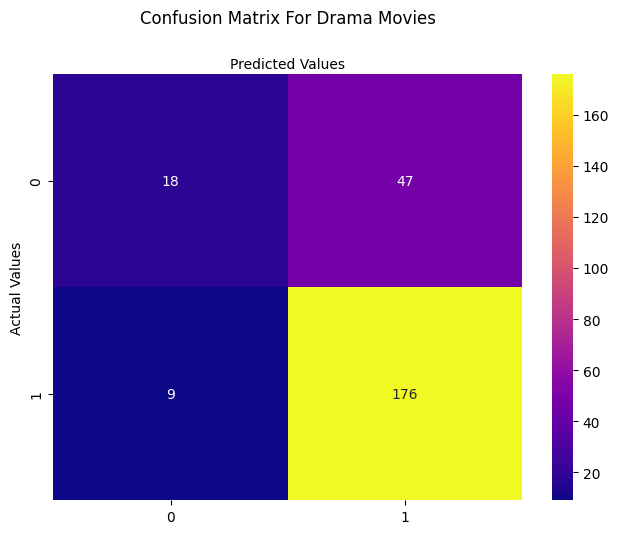

In [266]:
categories = [0,1] 
fig, ax = plt.subplots()
plt.xticks([0,1], categories)
plt.yticks([0,1], categories)
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="plasma" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix For Drama Movies', y=1.1)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

In [267]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.776
Precision: 0.7892376681614349
Recall: 0.9513513513513514


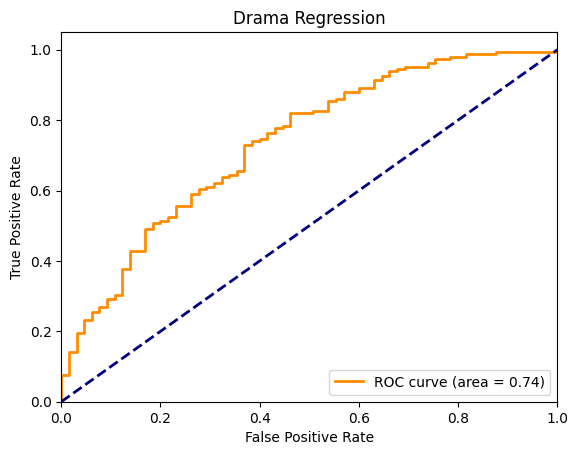

In [268]:
y_pred_proba = LogReg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Drama Regression')
plt.legend(loc="lower right")
plt.show()


## Adventure vs Non-Adventure Movies

In [269]:
# Made a dataframe with all of the movies that have war in the genre
genre = 'Adventure'
adventure = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin([genre]).any())]

In [270]:
adventure = adventure.reset_index()
adventure

,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating,Director,No_of_Votes,Outcome
0,The Lord of the Rings: The Return of the King,2003,201,"Action, Adventure, Drama",8.9,383,1642758,1
1,Inception,2010,148,"Action, Adventure, Sci-Fi",8.8,83,2067042,0
2,The Lord of the Rings: The Fellowship of the Ring,2001,178,"Action, Adventure, Drama",8.8,383,1661481,1
3,The Lord of the Rings: The Two Towers,2002,179,"Action, Adventure, Drama",8.7,383,1485555,1
4,Star Wars: Episode V - The Empire Strikes Back,1980,124,"Action, Adventure, Fantasy",8.7,191,1159315,0
...,...,...,...,...,...,...,...,...
191,Mad Max 2,1981,96,"Action, Adventure, Sci-Fi",7.6,159,166588,0
192,The Muppet Movie,1979,95,"Adventure, Comedy, Family",7.6,204,32802,0
193,Watership Down,1978,91,"Animation, Adventure, Drama",7.6,312,33656,1
194,Kelly's Heroes,1970,144,"Adventure, Comedy, War",7.6,61,45338,0


In [271]:
adventuremovielist = adventure['Series_Title'].to_list()

In [272]:
outcome2 = []
for movie in allmovielist:
    if movie in adventuremovielist:
        outcome2.append(1)
    else:
        outcome2.append(0)

In [273]:
adventure_df = movie_df
adventure_df['Outcome'] = outcome2

In [274]:
adventure_df

,Released_Year,Runtime,Genre,IMDB_Rating,Director,No_of_Votes,Outcome
Series_Title,,,,,,,
The Shawshank Redemption,1994,142,Drama,9.3,141,2343110,0
The Godfather,1972,175,"Crime, Drama",9.2,137,1620367,0
The Dark Knight,2008,152,"Action, Crime, Drama",9.0,83,2303232,0
The Godfather: Part II,1974,202,"Crime, Drama",9.0,137,1129952,0
12 Angry Men,1957,96,"Crime, Drama",9.0,456,689845,0
...,...,...,...,...,...,...,...
Breakfast at Tiffany's,1961,115,"Comedy, Drama, Romance",7.6,50,166544,0
Giant,1956,201,"Drama, Western",7.6,164,34075,0
From Here to Eternity,1953,118,"Drama, Romance, War",7.6,145,43374,0


In [275]:
A = adventure_df.drop(columns=['Outcome', 'Genre']) 
b = adventure_df.Outcome

In [276]:
A.head()

,Released_Year,Runtime,IMDB_Rating,Director,No_of_Votes
Series_Title,,,,,
The Shawshank Redemption,1994,142,9.3,141,2343110
The Godfather,1972,175,9.2,137,1620367
The Dark Knight,2008,152,9.0,83,2303232
The Godfather: Part II,1974,202,9.0,137,1129952
12 Angry Men,1957,96,9.0,456,689845


### Split the data into train and test data

In [277]:
A_train,A_test,b_train,b_test=train_test_split(A,b,test_size=0.25,random_state=0)

### Use scikit-learn Logistic Regression for training and testing your model

In [278]:
LogReg = LogisticRegression()


scaler = preprocessing.StandardScaler()
A_train = scaler.fit_transform(A_train)
A_test = scaler.transform(A_test)

LogReg.fit(A_train,b_train)


b_pred=LogReg.predict(A_test)

In [279]:
print('Classes', LogReg.classes_)
print('Intercept',LogReg.intercept_)
print("Coefficients", LogReg.coef_ )

Classes [0 1]
Intercept [-1.57668426]
Coefficients [[-0.05045878  0.15464671 -0.47941913  0.08841989  0.78854396]]


### Precision, Recall, and F1-score

Precision is the proportion of the predicted positives that are true positives.
Recall is the proportion of the true positives that are predicted as positives.
The F1 score is a measure of accuracy; it is the harmonic mean of the precision and recall

In [280]:
print("Accuracy", LogReg.score(A_test, b_test))
print(classification_report(b_test, LogReg.predict(A_test)))

Accuracy 0.78
              precision    recall  f1-score   support

           0       0.79      0.97      0.88       198
           1       0.29      0.04      0.07        52

    accuracy                           0.78       250
   macro avg       0.54      0.51      0.47       250
weighted avg       0.69      0.78      0.71       250



In [281]:
conf_mat = confusion_matrix(b_test, b_pred)
conf_mat

array([[193,   5],
       [ 50,   2]], dtype=int64)

### Plot the Confusion Matrix

In the confusion matrix above rows represent actual values and columns represent predicted values. The outcome of the confusion matrix is that there were 193 True Negative Values, 5 False Positive Values, 50 False Negative Values, and 2 True Positive Values.

Text(0.5, 427.9555555555555, 'Predicted Value')

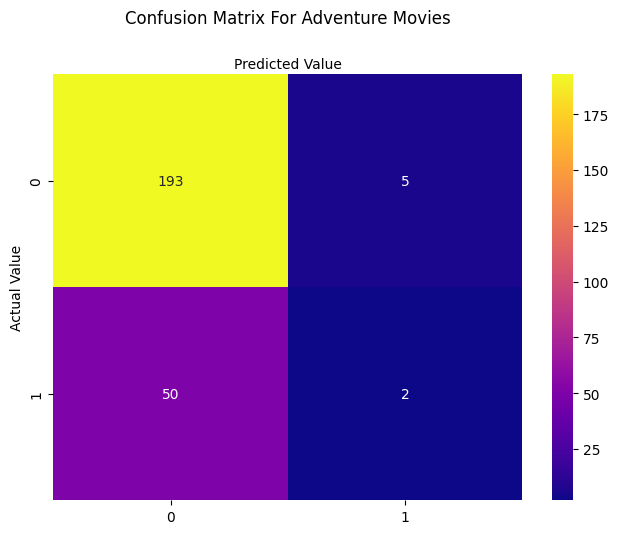

In [282]:
categories = [0,1] 
fig, ax = plt.subplots()
plt.xticks([0,1], categories)
plt.yticks([0,1], categories)
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="plasma" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix For Adventure Movies', y=1.1)
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')

In [283]:
print("Accuracy:", accuracy_score(b_test, b_pred))
print("Precision:", precision_score(b_test, b_pred))
print("Recall:", recall_score(b_test, b_pred))

Accuracy: 0.78
Precision: 0.2857142857142857
Recall: 0.038461538461538464


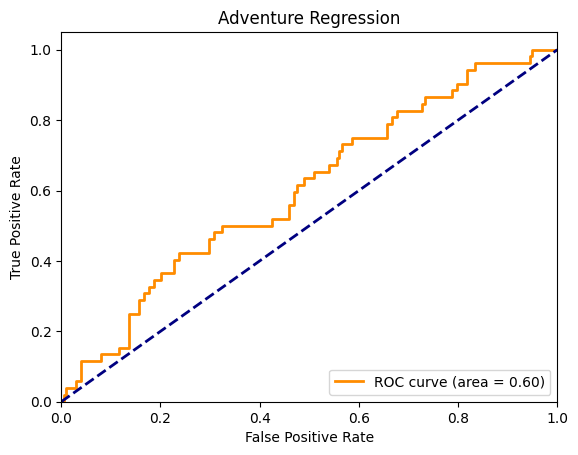

In [284]:
b_pred_proba = LogReg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(b_test,  b_pred_proba)
auc = roc_auc_score(b_test, b_pred_proba)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adventure Regression')
plt.legend(loc="lower right")
plt.show()

## Average Runtime of Movie Genres

In [285]:
adventure = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Adventure']).any())]
drama = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Drama']).any())]
crime = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Crime']).any())]
action = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Action']).any())]
scifi = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Sci-Fi']).any())]
fantasy = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Fantasy']).any())]
comedy = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Comedy']).any())]
war = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['War']).any())]
animation = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Animation']).any())]
thriller = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Thriller']).any())]
western = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Western']).any())]
biography = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Biography']).any())]
history = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['History']).any())]
mystery = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Mystery']).any())]
horror = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Horror']).any())]
music = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Music']).any())]
musical = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Musical']).any())]
sport = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Sport']).any())]
romance = movie_df[movie_df['Genre'].apply(lambda x: pd.Series(x.split(', ')).isin(['Romance']).any())]

In [286]:
a = adventure['Runtime'].sum() / adventure['Runtime'].count()
b = drama['Runtime'].sum() / drama['Runtime'].count()
c = crime['Runtime'].sum() / crime['Runtime'].count()
d = action['Runtime'].sum() / action['Runtime'].count()
e = scifi['Runtime'].sum() / scifi['Runtime'].count()
f = fantasy['Runtime'].sum() / fantasy['Runtime'].count()
g = comedy['Runtime'].sum() / comedy['Runtime'].count()
h = war['Runtime'].sum() / war['Runtime'].count()
i = animation['Runtime'].sum() / animation['Runtime'].count()
j = thriller['Runtime'].sum() / thriller['Runtime'].count()
k = western['Runtime'].sum() / western['Runtime'].count()
l = biography['Runtime'].sum() / biography['Runtime'].count()
m = history['Runtime'].sum() / history['Runtime'].count()
n = mystery['Runtime'].sum() / mystery['Runtime'].count()
o = horror['Runtime'].sum() / horror['Runtime'].count()
p = music['Runtime'].sum() / music['Runtime'].count()
q = musical['Runtime'].sum() / musical['Runtime'].count()
r = sport['Runtime'].sum() / sport['Runtime'].count()
s = romance['Runtime'].sum() / romance['Runtime'].count()

In [287]:
print(f'Average Runtime of Movie Genres\n\n'
    f'Adventure: {a}\n'
    f'Drama: {b}\n'
    f'Crime: {c}\n'
    f'Action: {d}\n'
    f'Sci-Fi: {e}\n'
    f'Fantasy: {f}\n'
    f'Comedy: {g}\n'
    f'War: {h}\n'
    f'Animation: {i}\n'
    f'Thriller: {j}\n'
    f'Western: {k}\n'
    f'Biography: {l}\n'
    f'History: {m}\n'
    f'Mystery: {n}\n'
    f'Horror: {o}\n'
    f'Music: {p}\n'
    f'Musical: {q}\n'
    f'Sport: {r}\n'
    f'Romance: {s}\n')

Average Runtime of Movie Genres

Adventure: 125.5
Drama: 126.70165745856353
Crime: 123.4401913875598
Action: 126.72486772486772
Sci-Fi: 120.80597014925372
Fantasy: 114.77272727272727
Comedy: 111.63948497854078
War: 132.0392156862745
Animation: 99.58536585365853
Thriller: 119.64233576642336
Western: 134.6
Biography: 135.6697247706422
History: 143.55357142857142
Mystery: 121.14141414141415
Horror: 102.5
Music: 120.74285714285715
Musical: 140.2941176470588
Sport: 132.6315789473684
Romance: 119.928



## Average IMDB_Rating for Movie Genres

In [288]:
a2 = adventure['IMDB_Rating'].sum() / adventure['IMDB_Rating'].count()
b2 = drama['IMDB_Rating'].sum() / drama['IMDB_Rating'].count()
c2 = crime['IMDB_Rating'].sum() / crime['IMDB_Rating'].count()
d2 = action['IMDB_Rating'].sum() / action['IMDB_Rating'].count()
e2 = scifi['IMDB_Rating'].sum() / scifi['IMDB_Rating'].count()
f2 = fantasy['IMDB_Rating'].sum() / fantasy['IMDB_Rating'].count()
g2 = comedy['IMDB_Rating'].sum() / comedy['IMDB_Rating'].count()
h2 = war['IMDB_Rating'].sum() / war['IMDB_Rating'].count()
i2 = animation['IMDB_Rating'].sum() / animation['IMDB_Rating'].count()
j2 = thriller['IMDB_Rating'].sum() / thriller['IMDB_Rating'].count()
k2 = western['IMDB_Rating'].sum() / western['IMDB_Rating'].count()
l2 = biography['IMDB_Rating'].sum() / biography['IMDB_Rating'].count()
m2 = history['IMDB_Rating'].sum() / history['IMDB_Rating'].count()
n2 = mystery['IMDB_Rating'].sum() / mystery['IMDB_Rating'].count()
o2 = horror['IMDB_Rating'].sum() / horror['IMDB_Rating'].count()
p2 = music['IMDB_Rating'].sum() / music['IMDB_Rating'].count()
q2 = musical['IMDB_Rating'].sum() / musical['IMDB_Rating'].count()
r2 = sport['IMDB_Rating'].sum() / sport['IMDB_Rating'].count()
s2 = romance['IMDB_Rating'].sum() / romance['IMDB_Rating'].count()

In [289]:
print(f'Average IMDB_Rating of Movie Genres\n\n'
    f'Adventure: {a2}\n'
    f'Drama: {b2}\n'
    f'Crime: {c2}\n'
    f'Action: {d2}\n'
    f'Sci-Fi: {e2}\n'
    f'Fantasy: {f2}\n'
    f'Comedy: {g2}\n'
    f'War: {h2}\n'
    f'Animation: {i2}\n'
    f'Thriller: {j2}\n'
    f'Western: {k2}\n'
    f'Biography: {l2}\n'
    f'History: {m2}\n'
    f'Mystery: {n2}\n'
    f'Horror: {o2}\n'
    f'Music: {p2}\n'
    f'Musical: {q2}\n'
    f'Sport: {r2}\n'
    f'Romance: {s2}\n')

Average IMDB_Rating of Movie Genres

Adventure: 7.952040816326531
Drama: 7.95939226519337
Crime: 7.954545454545454
Action: 7.9486772486772495
Sci-Fi: 7.977611940298509
Fantasy: 7.931818181818182
Comedy: 7.9034334763948495
War: 8.01372549019608
Animation: 7.930487804878048
Thriller: 7.909489051094892
Western: 7.999999999999998
Biography: 7.9357798165137625
History: 7.953571428571428
Mystery: 7.9676767676767675
Horror: 7.8875
Music: 7.9142857142857155
Musical: 7.947058823529411
Sport: 7.9263157894736835
Romance: 7.925600000000001

